# Применение Zero-shot Learning

Цель: Попрактиковаться с техникой Zero-shot, создать свой пайплайн из нескольких нейронных сетей. Приобрести опыт работы с SAM.

## №1. Детекция с помощью YOLO-world

Установим и импортируем необходимые зависимости

In [1]:
%pip install ultralytics --quiet
%pip install patched-yolo-infer --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import cv2
import torch
import matplotlib.pyplot as plt

from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from patched_yolo_infer import visualize_results_usual_yolo_inference

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Попробуем детектировать автомобили и автобусы на спутниковых снимках

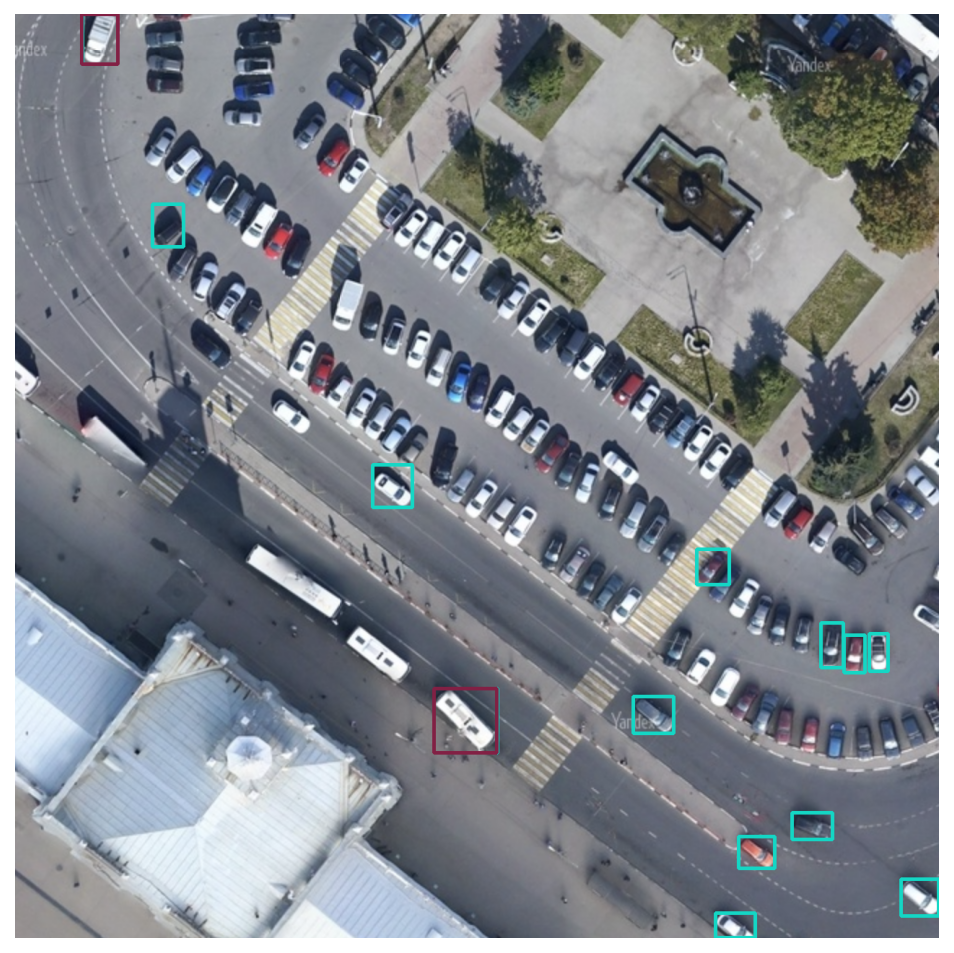

In [63]:
default_model = YOLO('yolov8l-worldv2.pt')

default_model.set_classes(["car", "bus"])

img_path = 'images/4.png'
img = cv2.imread(img_path)

visualize_results_usual_yolo_inference(
    img,
    default_model,
    imgsz=640,
    conf=0.1,
    iou=0.7,
    segment=False,
    delta_colors=0,
    thickness=4,
    font_scale=1.0,
    show_boxes=True,
    random_object_colors=False,
    show_confidences=False,
    show_class=False
)

Меньший конфиденс приводит к случайным ложным срабатываниям

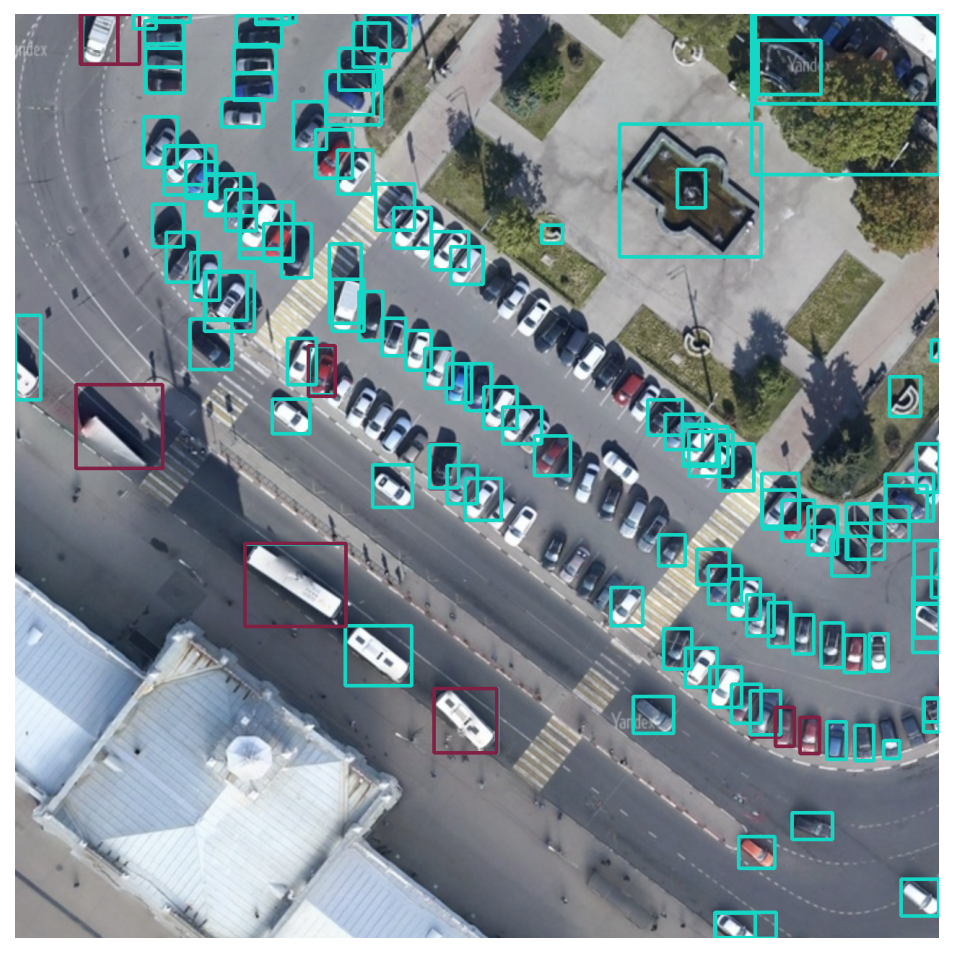

In [64]:
default_model.set_classes(["car", "bus"])

img_path = 'images/4.png'
img = cv2.imread(img_path)

visualize_results_usual_yolo_inference(
    img,
    default_model,
    imgsz=640,
    conf=0.01,
    iou=0.7,
    segment=False,
    delta_colors=0,
    thickness=4,
    font_scale=1.0,
    show_boxes=True,
    random_object_colors=False,
    show_confidences=False,
    show_class=False
)

Подбор подходящего промпта имени класса не спасает ситуацию

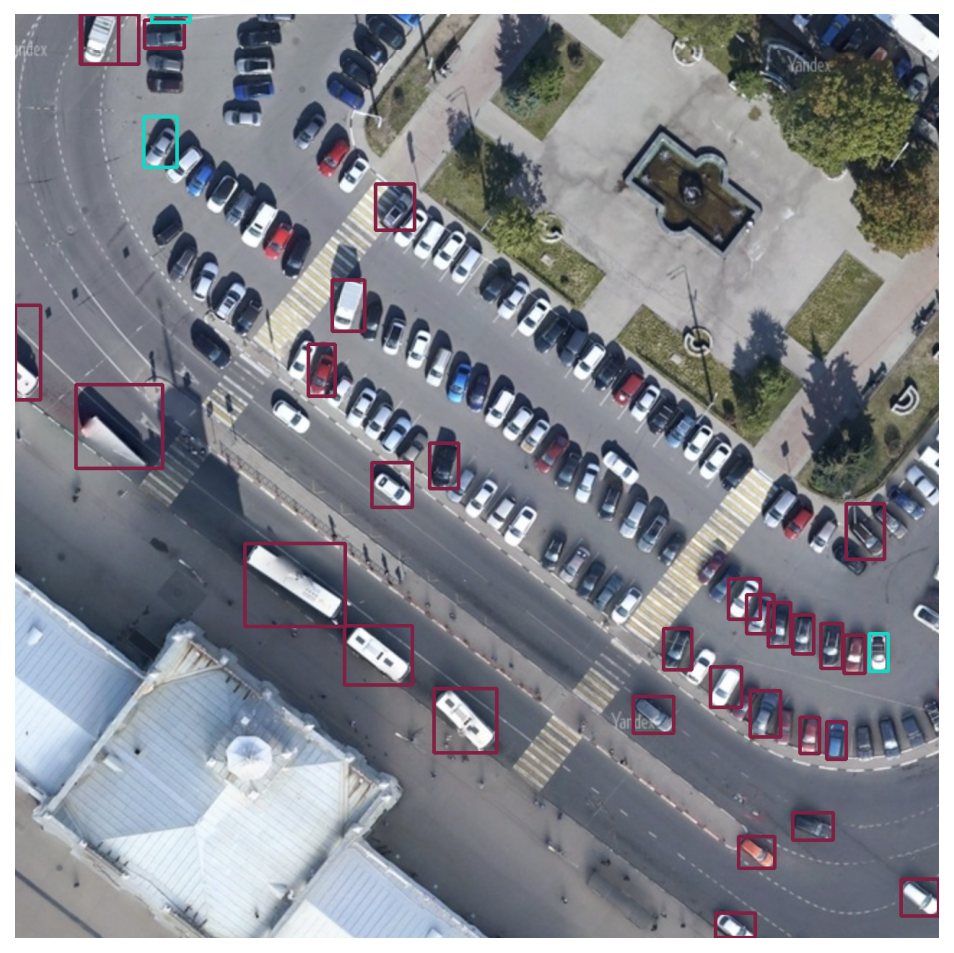

In [5]:
default_model = YOLO('yolov8l-worldv2.pt')

default_model.set_classes(["vehicle", "bus"])

img_path = 'images/4.png'
img = cv2.imread(img_path)

visualize_results_usual_yolo_inference(
    img,
    default_model,
    imgsz=640,
    conf=0.01,
    iou=0.7,
    segment=False,
    delta_colors=0,
    thickness=4,
    font_scale=1.0,
    show_boxes=True,
    random_object_colors=False,
    show_confidences=False,
    show_class=False
)

Судя по всему, готовая модель от ultralitics не имела достаточного количества таких снимков в обучающем датасете, поэтому дообучим на датасете DOTAv1 (спутниковые снимки городской инфраструктуры, 1411 снимков в train-выборке)

In [4]:
model = YOLO('yolov8l-worldv2.pt') 
results = model.train(data="DOTAv1.yaml", epochs=10, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.67 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
engine/trainer: task=detect, mode=train, model=yolov8l-worldv2.pt, data=DOTAv1.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning /home/jupyter/work/resources/detectors/datasets/DOTAv1/labels/train.cache... 1411 images, 2 backgrounds, 1 corrupt: 100%|██████████| 1411/1411 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/jupyter/work/resources/detectors/datasets/DOTAv1/images/train/P1872.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6534      1.8034      1.7907      1.7744      1.7483       1.723      1.6903      1.8182      1.6506      1.6087      1.6596       1.213        1.61      1.5594        1.51      1.5529      1.4456      1.4922      1.3925       1.364      1.3362       1.822      1.8426      1.8735      2.0144      2.2527
       2.097      2.1098       2.178      2.2118      2.2618      2.2772      2.2437      2.1674      2.0553      2.0337      2.0154      1.9993       1.998      1.9395      1.8671      1.8864      1.9115      1.9278      1.2735      1.1513      1.2916      1.1644      1.1396      1.3352      1.4364      1.2961
      1.1785      1.1532      1.2294      1.2884      1.3137       1.033      1.0843      1.0808      1.0927      1.0347      2.3171      2.2918      2.3637      2.4091       2.667      2.7528      2.774


val: Scanning /home/jupyter/work/resources/detectors/datasets/DOTAv1/labels/val.cache... 458 images, 2 backgrounds, 0 corrupt: 100%|██████████| 458/458 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 104 weight(decay=0.0), 115 weight(decay=0.0005), 121 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      26.7G      1.831      2.639      1.211          3        640: 100%|██████████| 89/89 [01:33<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


                   all        458      28853       0.48      0.215      0.214      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      27.2G      1.553      1.261      1.039        103        640: 100%|██████████| 89/89 [01:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


                   all        458      28853      0.659      0.254      0.277      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      27.2G      1.492      1.096      1.008         59        640: 100%|██████████| 89/89 [01:05<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


                   all        458      28853      0.565      0.286      0.303      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      21.7G      1.461     0.9963     0.9915         37        640: 100%|██████████| 89/89 [01:08<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        458      28853      0.646      0.327      0.355      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      26.5G      1.401     0.9495     0.9813        460        640: 100%|██████████| 89/89 [01:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        458      28853      0.651       0.34      0.368      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      20.5G      1.377     0.8763     0.9623         16        640: 100%|██████████| 89/89 [01:07<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


                   all        458      28853      0.727       0.36      0.403      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      24.6G      1.333     0.8199     0.9582         46        640: 100%|██████████| 89/89 [01:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


                   all        458      28853      0.683      0.383      0.417      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      21.8G       1.31      0.792     0.9373        603        640: 100%|██████████| 89/89 [01:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


                   all        458      28853      0.673      0.388      0.426      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      25.4G       1.28     0.7885     0.9428         11        640: 100%|██████████| 89/89 [01:06<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


                   all        458      28853      0.704      0.397      0.435       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      22.2G      1.232     0.7241     0.9238         19        640: 100%|██████████| 89/89 [01:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


                   all        458      28853      0.677      0.406      0.442      0.277

10 epochs completed in 0.236 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 94.1MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 94.1MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
YOLOv8l-worldv2 summary (fused): 295 layers, 46807922 parameters, 0 gradients, 180.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:06<00:00,  4.45s/it]


                   all        458      28853      0.681      0.405      0.442      0.277
                 plane         70       2531      0.832      0.644      0.684      0.416
                  ship        108       8960      0.767      0.473       0.54      0.271
          storage tank         55       2888      0.762       0.19      0.284       0.13
      baseball diamond         53        214      0.756      0.294      0.404      0.231
          tennis court         94        760        0.9      0.863      0.907      0.802
      basketball court         35        132      0.626      0.317      0.361      0.273
    ground track field         70        144      0.675      0.375      0.385      0.259
                harbor        114       2090      0.704      0.632      0.671      0.346
                bridge         75        464      0.445     0.0518     0.0642     0.0284
         large vehicle        110       4387      0.758      0.759       0.77      0.537
         small vehicl

In [5]:
model.save('yolov8l-worldv2_trained.pt')

In [61]:
model.set_classes(["large vehicle", "car"])

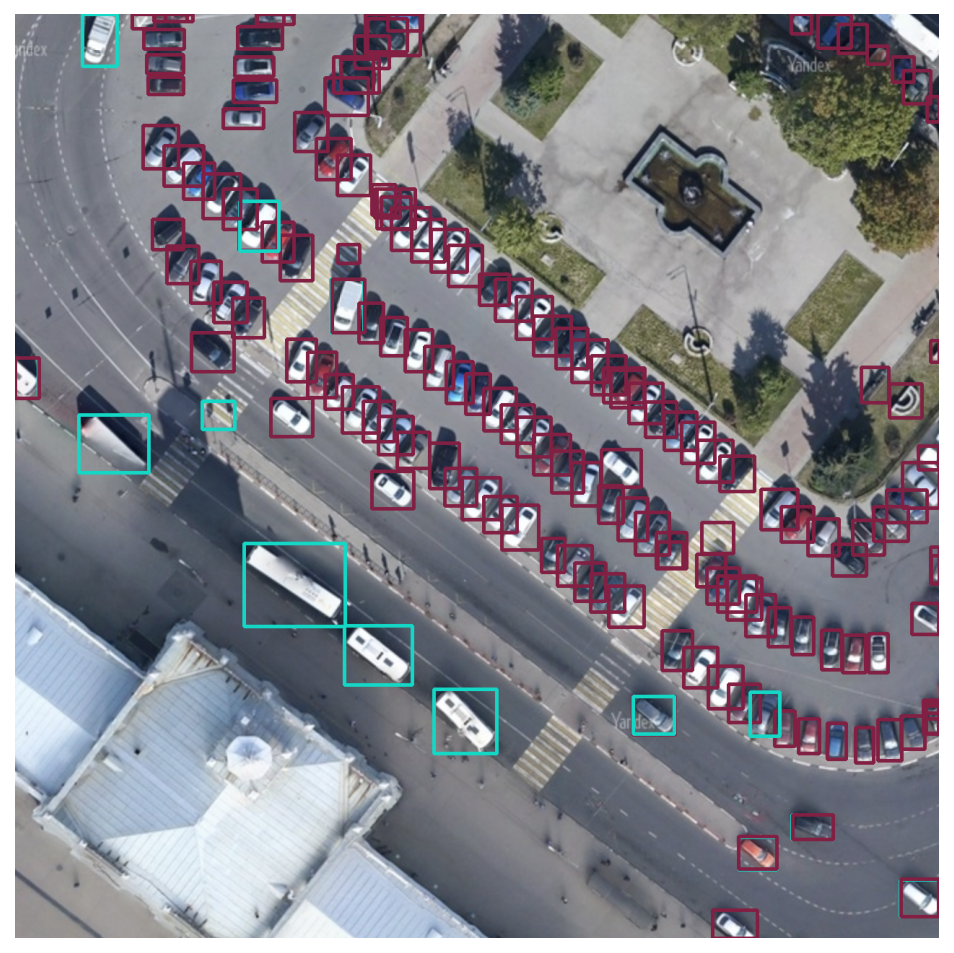

In [62]:
img_path = 'images/4.png'
img = cv2.imread(img_path)

visualize_results_usual_yolo_inference(
    img,
    model,
    imgsz=640,
    conf=0.01,
    iou=0.7,
    segment=False,
    delta_colors=0,
    thickness=4,
    font_scale=1.0,
    show_boxes=True,
    random_object_colors=False,
    show_confidences=False,
    show_class=False
)

Класс "car" дает стабильно лучший относительно исходной модели результат, но добиться более-менее стабильного детектирования автобусов удалось только классом "large vehicle", соответствующего одному из классов датасета DOTA

## №1 *. Распознавание номеров машин с помощью связки YOLO-world + TrOCR

Реализуем распознавание номеров

Используем стандартную модель и класс "license plate". Добавляем класс для фона, чтобы улучшить результаты работы детектора. 

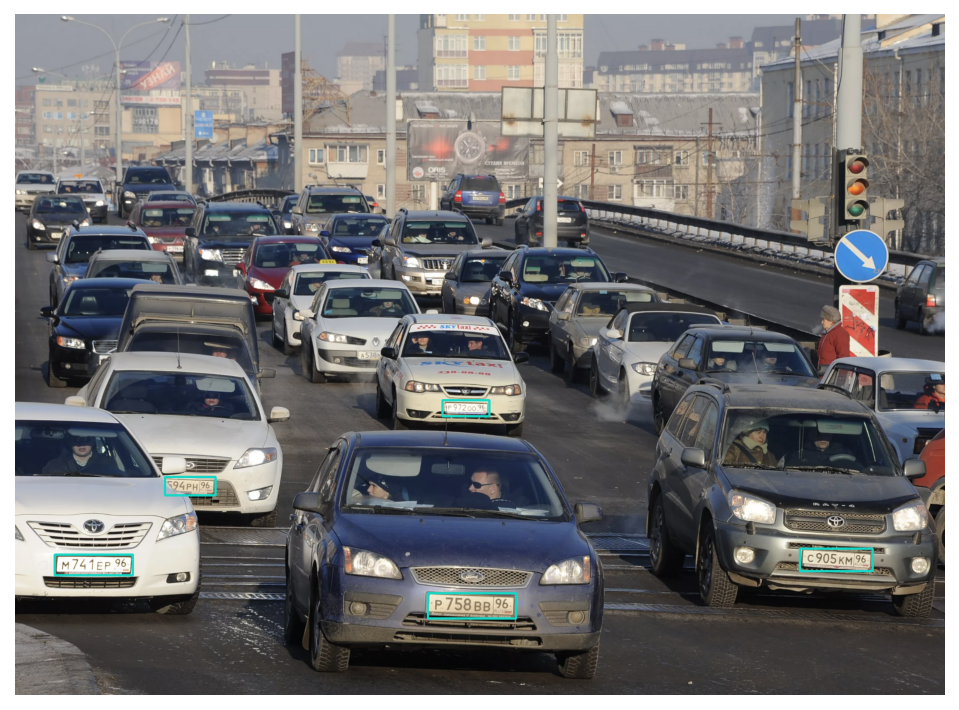

In [3]:
model = YOLO('yolov8l-worldv2.pt')

model.set_classes(["license plate", ""])

img_path = 'images/5.png'
img = cv2.imread(img_path)

visualize_results_usual_yolo_inference(
    img,
    model,
    imgsz=1600,
    conf=0.1,
    iou=0.01,
    segment=False,
    delta_colors=0,
    thickness=4,
    font_scale=1.0,
    show_boxes=True,
    random_object_colors=False,
    show_confidences=False,
    show_class=False
)

Последовательно идем по результатам детектирования и распознаем текст на вырезанных из изображения регионах интереса

In [4]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
tcr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


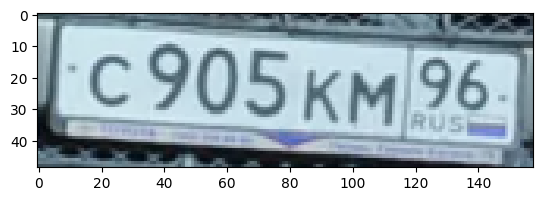

Lisence plate: C905KM96


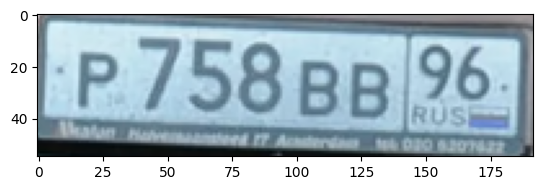

Lisence plate: P 758BB 96


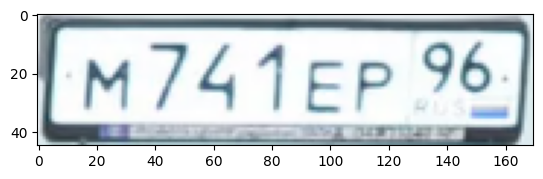

Lisence plate: (M741EP %)


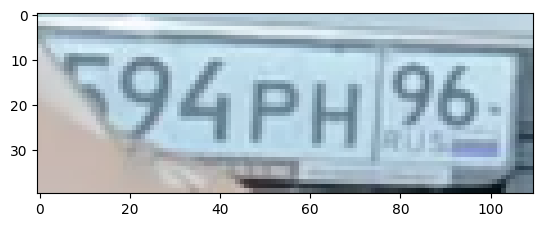

Lisence plate: 594PH96


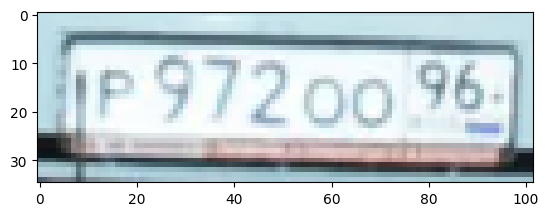

Lisence plate: (P 97200.96)


In [5]:
predictions = model.predict(img, imgsz=1600, conf=0.1, iou=0.01, verbose=False)
boxes = predictions[0].boxes

for box in list(predictions[0].boxes.xyxy):
    x1, y1, x2, y2 = map(int, box)
    crop = img[y1:y2, x1:x2]

    plt.imshow(crop)
    plt.show()
    
    pixel_values = processor(crop, return_tensors="pt").pixel_values
    with torch.no_grad():
        generated_ids = tcr_model.generate(pixel_values, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print("Lisence plate:", generated_text)

## №2. Превращаем модель в инстанс сегментатор

Импортируем SAM модель

In [6]:
from transformers import SamModel, SamProcessor

Выполним сегментацию по полученным ранее боксам и получим итоговые маски

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

input_boxes = [[float(coord) for coord in  box] for box in list(predictions[0].boxes.xyxy)]
inputs = processor(images=[img], input_boxes=[input_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)[0]

Сложим все маски в одну и визуализируем красным каналом

In [145]:
mask = torch.sum(masks, dim=0).to(torch.int)
mask[0] *= 300
mask -= 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


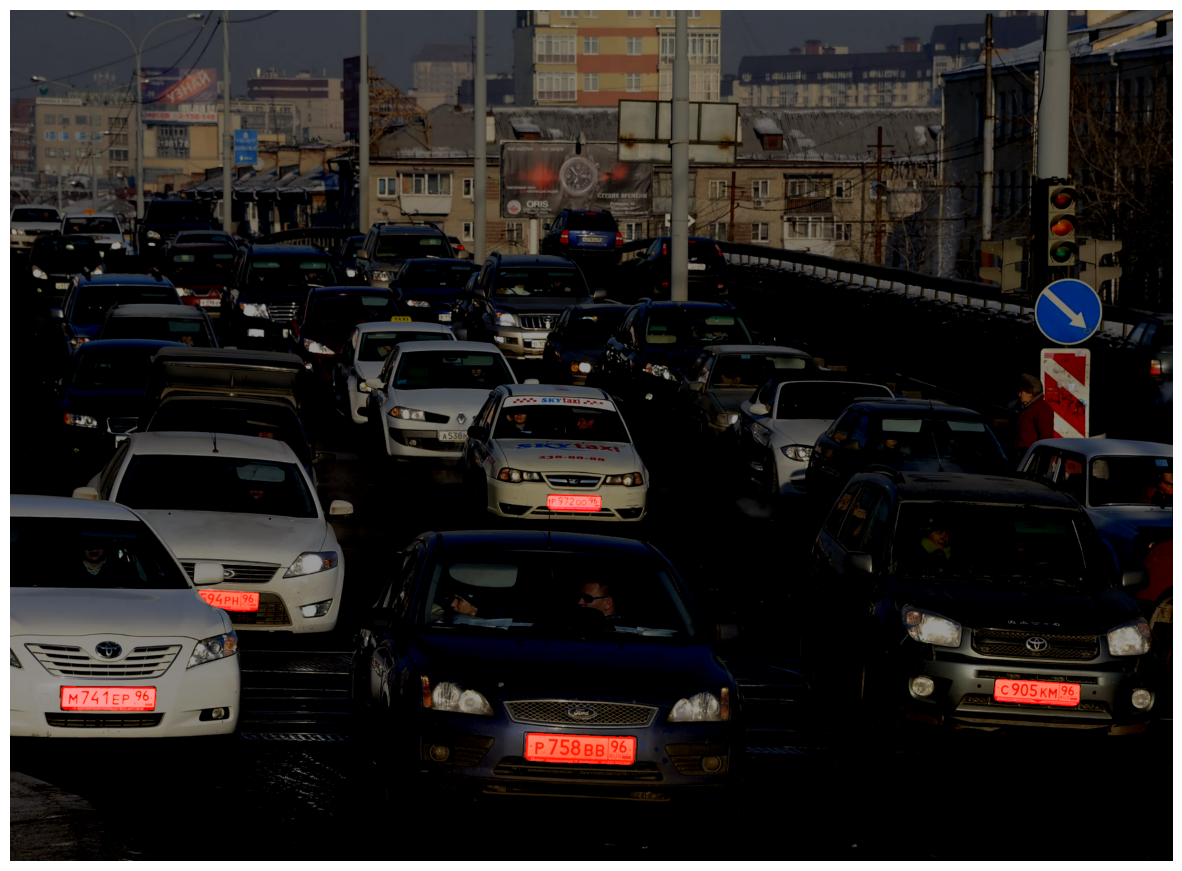

In [146]:
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(torch.tensor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) + mask.permute([1,2,0]))
plt.show()